In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import joblib
class CFG:
    MODEL_NAME = 'vinai/bertweet-base'
    TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)

    MAX_LEN = 128
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Training Hyperparameters (kept identical to original) ---
    FP16 = True
    EPOCHS = 50
    LEARNING_RATE = 3e-5
    BATCH_SIZE = 8
    ACCUMULATION_STEPS = 2
    WARMUP_RATIO = 0.06
    LABEL_SMOOTHING = 0.1
    WEIGHT_DECAY = 0.01
    SCHEDULER = "r-drop"
    DROPOUT = 0.3
    CLIP_GRAD_NORM = 1.0
    R_DROP_ALPHA = 5
    NUM_WORKERS = 0
    WANDB_PROJECT = "BERT-Emotion-Ensemble"
    PATIENCE = 4

    # --- Ensemble Additions ---
    DRIVE_PATH = '/content/drive/My Drive/Emotion_BERT_Ensemble_Models'
    SEEDS = [101, 2468, 90210, 3141, 5555]
    MODEL_FILES = [f"model_seed_{s}.pth" for s in SEEDS]


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL_NAME)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [ ]:
import re

In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 17.7 MB/s eta 0:00:00


In [ ]:
from unidecode import unidecode

In [ ]:
# Load data
train_df = pd.read_csv("emotion-labels-train.csv")
val_df = pd.read_csv("emotion-labels-val.csv")
test_df = pd.read_csv("emotion-labels-test.csv")

# Preprocessing function
def pre_process_document(text):
    text = re.sub(r'<[^>]+>', ' ', text)
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = unidecode(text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Apply preprocessing and label encoding
train_df['text'] = train_df['text'].apply(pre_process_document)
val_df['text'] = val_df['text'].apply(pre_process_document)
test_df['text'] = test_df['text'].apply(pre_process_document)

le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
val_df['label'] = le.transform(val_df['label'])
test_df['label'] = le.transform(test_df['label'])

NUM_CLASSES = len(le.classes_)
CLASS_NAMES = le.classes_
print(f"Classes: {CLASS_NAMES}")

Classes: ['anger' 'fear' 'joy' 'sadness']


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row.text
        label = row.label

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Ensure token_type_ids exist
        if 'token_type_ids' not in encoding:
            encoding['token_type_ids'] = torch.zeros_like(encoding['input_ids'])

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'token_type_ids': encoding['token_type_ids'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = BERTDataset(train_df, tokenizer, CFG.MAX_LEN)
val_dataset   = BERTDataset(val_df, tokenizer, CFG.MAX_LEN)
test_dataset  = BERTDataset(test_df, tokenizer, CFG.MAX_LEN)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.dropout = nn.Dropout(CFG.DROPOUT)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = bert_output.pooler_output  # original style
        dropped_output = self.dropout(pooled_output)
        logits = self.fc(dropped_output)
        return logits


In [ ]:
def load_model(model_path):
    model = BERTClassifier(CFG.MODEL_NAME, NUM_CLASSES)
    checkpoint = torch.load(model_path, map_location=CFG.DEVICE)
    model.load_state_dict(checkpoint)
    model.to(CFG.DEVICE)
    model.eval()
    return model

seed_models = []
for file in CFG.MODEL_FILES:
    path = os.path.join(CFG.DRIVE_PATH, file)
    if os.path.exists(path):
        model = load_model(path)
        seed_models.append(model)
        print(f"✅ Loaded {file}")
    else:
        print(f"⚠️ Missing: {file}")

print(f"\nTotal models loaded: {len(seed_models)}")

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

✅ Loaded model_seed_101.pth
✅ Loaded model_seed_2468.pth
✅ Loaded model_seed_90210.pth
✅ Loaded model_seed_3141.pth
✅ Loaded model_seed_5555.pth

Total models loaded: 5


In [ ]:
all_train_logits, all_val_logits, all_test_logits = [], [], []

def collect_logits(model, dataset):
    loader = DataLoader(dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)
    model_logits = []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(CFG.DEVICE)
            attention_mask = batch['attention_mask'].to(CFG.DEVICE)
            token_type_ids = batch.get('token_type_ids', None)
            if token_type_ids is not None:
                token_type_ids = token_type_ids.to(CFG.DEVICE)
            # forward (token_type_ids may be None and model handles it)
            logits = model(input_ids, attention_mask, token_type_ids)
            model_logits.append(logits.cpu().numpy())
    return np.concatenate(model_logits, axis=0)

In [ ]:
print(f"Collecting logits from {len(seed_models)} models. This may take a few minutes...")
for i, m in enumerate(seed_models, start=1):
    print(f" -> Model {i}/{len(seed_models)}")
    tr = collect_logits(m, train_dataset)
    va = collect_logits(m, val_dataset)
    te = collect_logits(m, test_dataset)
    # quick sanity checks
    assert tr.shape[0] == len(train_dataset), f"train size mismatch model {i}"
    assert va.shape[0] == len(val_dataset), f"val size mismatch model {i}"
    assert te.shape[0] == len(test_dataset), f"test size mismatch model {i}"
    all_train_logits.append(tr)
    all_val_logits.append(va)
    all_test_logits.append(te)

print("✅ Done collecting logits.")
print(f"Shapes (per model): train {all_train_logits[0].shape}, val {all_val_logits[0].shape}, test {all_test_logits[0].shape}")

 -> Model 1/5
 -> Model 2/5
 -> Model 3/5
 -> Model 4/5
 -> Model 5/5
✅ Done collecting logits.
Shapes (per model): train (3613, 4), val (347, 4), test (3142, 4)


In [ ]:
#average logits across the models (exactly as original notebook)
def calculate_metrics(labels, preds):
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted'),
        "precision": precision_score(labels, preds, average='weighted', zero_division=0),
        "recall": recall_score(labels, preds, average='weighted', zero_division=0)
    }

# Average logits (axis=0 averages across the model-list)
ensemble_train_logits = np.mean(all_train_logits, axis=0)
ensemble_val_logits   = np.mean(all_val_logits, axis=0)
ensemble_test_logits  = np.mean(all_test_logits, axis=0)

train_preds = np.argmax(ensemble_train_logits, axis=1)
val_preds   = np.argmax(ensemble_val_logits, axis=1)
test_preds  = np.argmax(ensemble_test_logits, axis=1)

train_final_metrics = calculate_metrics(train_df['label'].values, train_preds)
val_final_metrics   = calculate_metrics(val_df['label'].values, val_preds)
test_final_metrics  = calculate_metrics(test_df['label'].values, test_preds)

ensemble_logits_results = pd.DataFrame({
    'Train': train_final_metrics,
    'Validation': val_final_metrics,
    'Test': test_final_metrics
}).T

print("\n📊 Final Ensemble (Average logits) Performance 📊")
display(ensemble_logits_results)



📊 Final Ensemble (Average logits) Performance 📊


,accuracy,f1,precision,recall
Train,0.963742,0.963809,0.963956,0.963742
Validation,0.904899,0.904844,0.904979,0.904899
Test,0.886378,0.886561,0.887559,0.886378


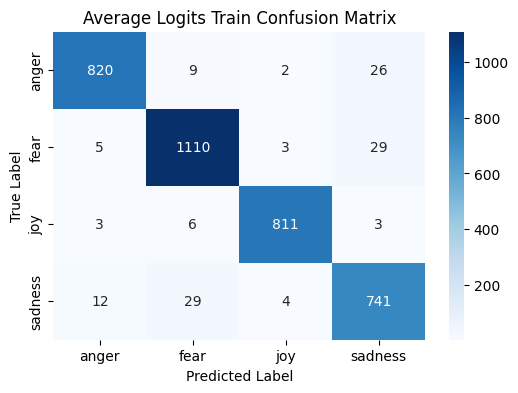

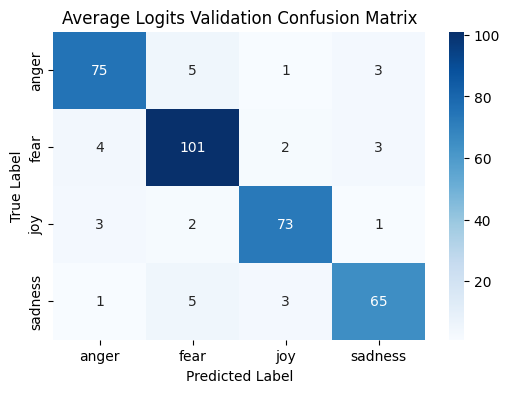

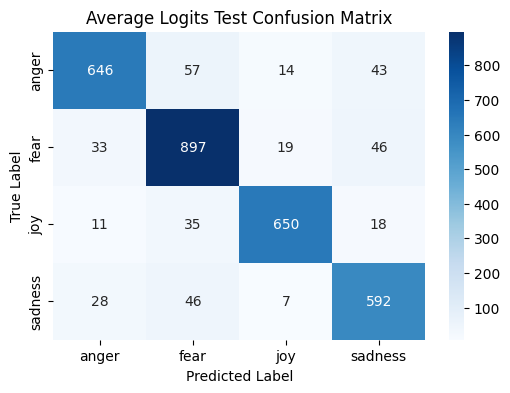

In [ ]:
#generate confusion matrices
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(labels, preds, class_names, title):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Get predictions from the average logits model (already calculated in the previous cell)
# train_preds, val_preds, test_preds

# Plot confusion matrices
plot_confusion_matrix(train_df['label'].values, train_preds, CLASS_NAMES, 'Average Logits Train Confusion Matrix')
plot_confusion_matrix(val_df['label'].values, val_preds, CLASS_NAMES, 'Average Logits Validation Confusion Matrix')
plot_confusion_matrix(test_df['label'].values, test_preds, CLASS_NAMES, 'Average Logits Test Confusion Matrix')

In [ ]:
# numpy softmax helper
def softmax_np(x):
    ex = np.exp(x - np.max(x, axis=1, keepdims=True))
    return ex / np.sum(ex, axis=1, keepdims=True)

# compute probability arrays per model
all_train_probs = [softmax_np(l) for l in all_train_logits]
all_val_probs   = [softmax_np(l) for l in all_val_logits]
all_test_probs  = [softmax_np(l) for l in all_test_logits]

# average probabilities across models
ensemble_train_probs = np.mean(all_train_probs, axis=0)
ensemble_val_probs   = np.mean(all_val_probs, axis=0)
ensemble_test_probs  = np.mean(all_test_probs, axis=0)

# Sanity: argmax of probs should be similar to argmax of logits in most cases
assert ensemble_train_probs.shape[0] == len(train_df)
assert ensemble_val_probs.shape[0] == len(val_df)
assert ensemble_test_probs.shape[0] == len(test_df)

# Standardize for SVM
scaler = StandardScaler()
X_train = scaler.fit_transform(ensemble_train_probs)
X_val   = scaler.transform(ensemble_val_probs)
X_test  = scaler.transform(ensemble_test_probs)

y_train = train_df['label'].values
y_val   = val_df['label'].values
y_test  = test_df['label'].values


In [ ]:

# Hyperparameter Tuning for SVM (RBF kernel)


from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# --- 1. Define the parameter grid ---
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# --- 2. GridSearchCV setup ---
grid_search = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)


In [ ]:
print("Starting Grid Search for SVM hyperparameters...")
grid_search.fit(X_train, y_train)


Starting Grid Search for SVM hyperparameters...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [ ]:
print(f"✅ Best parameters found: {grid_search.best_params_}")
best_svm = grid_search.best_estimator_

✅ Best parameters found: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


In [ ]:
def eval_and_return(model, X, y):
    preds = model.predict(X)
    return calculate_metrics(y, preds)

svm_train_metrics = eval_and_return(best_svm, X_train, y_train)
svm_val_metrics   = eval_and_return(best_svm, X_val, y_val)
svm_test_metrics  = eval_and_return(best_svm, X_test, y_test)

svm_results = pd.DataFrame({
    'Train': svm_train_metrics,
    'Validation': svm_val_metrics,
    'Test': svm_test_metrics
}).T

print("\n📊 Tuned Ensemble (prob avg) + SVM Stacking Performance 📊")
display(svm_results)



📊 Tuned Ensemble (prob avg) + SVM Stacking Performance 📊


,accuracy,f1,precision,recall
Train,0.964019,0.964066,0.964139,0.964019
Validation,0.907781,0.907732,0.907972,0.907781
Test,0.886060,0.886355,0.887361,0.886060


In [ ]:
svm_save_path = os.path.join(CFG.DRIVE_PATH, 'Emotion_BERT_SVM_Stack_TUNED.pkl')
joblib.dump((best_svm, scaler, le), svm_save_path)
print(f"Saved TUNED SVM+scaler+label-encoder to: {svm_save_path}")


Saved TUNED SVM+scaler+label-encoder to: /content/drive/My Drive/Emotion_BERT_Ensemble_Models/Emotion_BERT_SVM_Stack_TUNED.pkl


In [ ]:
best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']
print(f"\n🔍 Best C value: {best_C}")
print(f"🔍 Best gamma value: {best_gamma}")


🔍 Best C value: 1
🔍 Best gamma value: 0.01


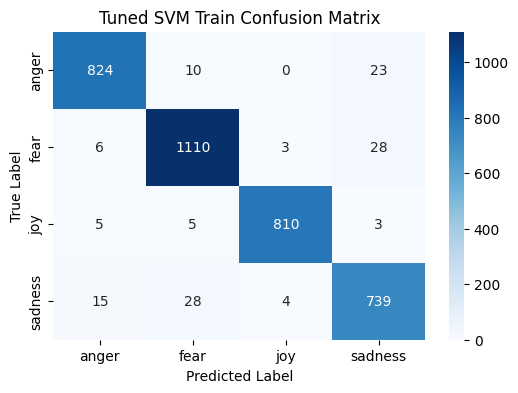

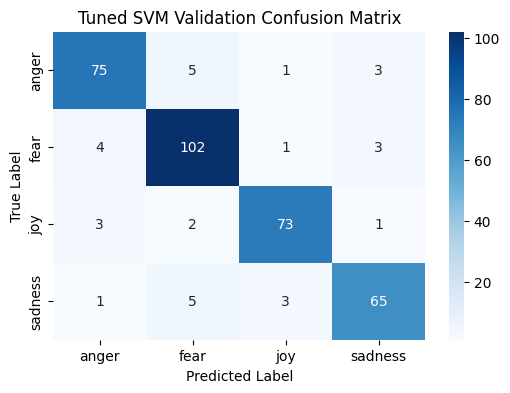

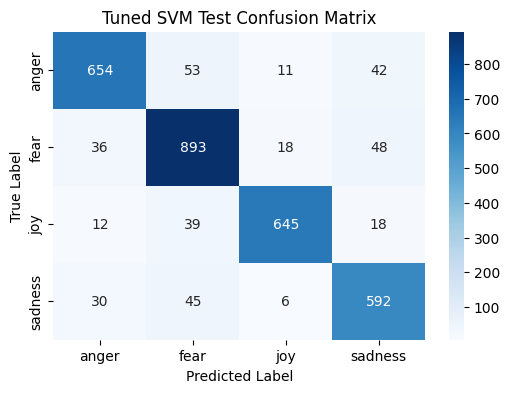

In [ ]:
#generate confusion matrices
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(labels, preds, class_names, title):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Get predictions from the tuned SVM model
svm_train_preds = best_svm.predict(X_train)
svm_val_preds   = best_svm.predict(X_val)
svm_test_preds  = best_svm.predict(X_test)


# Plot confusion matrices for the tuned SVM model
plot_confusion_matrix(y_train, svm_train_preds, CLASS_NAMES, 'Tuned SVM Train Confusion Matrix')
plot_confusion_matrix(y_val, svm_val_preds, CLASS_NAMES, 'Tuned SVM Validation Confusion Matrix')
plot_confusion_matrix(y_test, svm_test_preds, CLASS_NAMES, 'Tuned SVM Test Confusion Matrix')